# Exploration of Projection Spaces

## Imports

In [ ]:
#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

#plots the figures in place instead of a new window
%matplotlib inline

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable("vegafusion")

import umap.umap_ as umap
import os

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from matplotlib.animation import FuncAnimation, PillowWriter
import hdbscan

from IPython.display import Image
import base64, io, IPython
from PIL import Image as PILImage

## Data

### Details on Conway's Game of Life
[Conway's Game of Life - Wikipedia](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life)

#### Any live cell with fewer than two live neighbours dies
#### Any live cell with two or three live neighbours lives on to the next generation.
#### Any live cell with more than three live neighbours dies
#### Any dead cell with exactly three live neighbours becomes a live cell

### Data Generation & Utility Functions for Conways's Game of Life

In [ ]:
# Game of Life Utility Functions
# initializing the grid, counting neighbors, 
# and evolving the Game of Life by one step.

# Any live cell with fewer than two live neighbours dies
# Any live cell with two or three live neighbours lives on to the next generation.
# Any live cell with more than three live neighbours dies
# Any dead cell with exactly three live neighbours becomes a live cell

def initialize_grid(size, init_prob=(0.2, 0.5)):
    """
    Initialize a random grid for the Game of Life of a given size.
    Density stands for how likely it is for the initial state to be alive.
    """
    density = np.random.uniform(init_prob[0], init_prob[1])
    return np.random.choice([0, 1], size*size, p=[1-density, density]).reshape(size, size)
    

def count_neighbors(grid, x, y):
    # Count the number of alive neighbors for a cell in the grid.
    s = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            if i == 0 and j == 0:
                continue
            s += grid[(x + i) % grid.shape[0], (y + j) % grid.shape[1]]
    return s

def step(grid):
    # Advance the Game of Life by one step.
    new_grid = grid.copy()
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            neighbors = count_neighbors(grid, x, y)
            if grid[x, y] == 1:
                if neighbors < 2 or neighbors > 3:
                    new_grid[x, y] = 0
            else:
                if neighbors == 3:
                    new_grid[x, y] = 1
    return new_grid


def run_single_game(steps=10, grid_size=30, init_prob=(0.2, 0.5)):
    """
    Initializes the grid and runs it for a specified number of steps.
    """
    states = []
    initial_state = initialize_grid(size=grid_size, init_prob=init_prob)
    states.append(initial_state)
    
    for _ in range(steps - 1):
        states.append(step(states[-1]))

    return states


def generate_data(grid_size=30, steps=20, ngames=50, init_prob=(0.2, 0.5)):
    """
    Generate data comprised of several games, each game consists of multiple states.
    Add metadata: step, game number, periodicity, whether state is stable or not.
    """

    # create a list of column names for the pandas df -> according to the size of the grid
    col_names = ["step", "game_n", "stable", "period"]
    
    for x in range(grid_size):
        for y in range(grid_size):
            col_names.append(f"{x}_{y}")
        
    data = pd.DataFrame(columns=col_names)

    
    for game in range(ngames):
        states = run_single_game(steps=steps, grid_size=grid_size, init_prob=init_prob)
        single_game = np.array([state.flatten() for state in states])
        
        # convert to pandas df with the same column names (except "step", "game_n")
        single_game_df = pd.DataFrame(single_game, columns=data.columns[4:])
        
        # add metadata: 
        # set the index of single_game_df to match the step
        single_game_df["step"] = single_game_df.index
        single_game_df["game_n"] = game
        check_stable_state(single_game_df)
        check_period(single_game_df)

        # order columns (same order as in data)
        single_game_df = single_game_df[data.columns]
        data = pd.concat([data, single_game_df], ignore_index=True)

    data = add_cells_status(data)

    return data


# util functions for meta data

def is_stable(row, prev_row):
    """
    Compares current row to the previous row:
    If values in all columns except columns_to_exclude are the same as in the prev row -> return True, otherwise return False
    """
    columns_to_exclude = ["game_n", "step", "stable"]
    return row.loc[~row.index.isin(columns_to_exclude)].eq(prev_row.loc[~prev_row.index.isin(columns_to_exclude)]).all()


def check_stable_state(df):
    """
    Creates a new column:
    If game states in current row are the same as previous row -> return 1, otherwise return 0.
    """
    # initialize the "stable" column with zeros
    df['stable'] = 0
    
    # Iterate through the DataFrame
    for i in range(1, len(df)):
        current_row = df.iloc[i]
        previous_row = df.iloc[i - 1]
        
        if is_stable(current_row, previous_row):
            df.at[i, 'stable'] = 1 


def check_period(df):
    """
    Creates a new column:
    If game states in current row are equivalent to one of the previous states -> return 1, otherwise return 0.
    """
    # initialize the "period" column with zeros
    df["period"] = 0

    # Define the columns to exclude from the comparison
    exclude_columns = ["game_n", "step", "stable", "period"]
    
    # Iterate through the DataFrame rows
    for i in range(1, len(df)):
        current_row = df.loc[i].drop(exclude_columns)  # Exclude specified columns for the current row
        previous_row = df.loc[i - 1].drop(exclude_columns)  # Exclude specified columns for the row above
    
        # Check if the current row matches the row above
        if current_row.equals(previous_row):
            df.at[i, "period"] = 1


def add_cells_status(df):
    """
    Adds info about whether the state is alive or not + additional metadata.
    """
    df["live_cells_count"] = df.drop(["step", "game_n", "stable", "period"], axis=1).sum(axis=1)
    df['alive'] = np.where(df["live_cells_count"] > 0, 1, 0)
    df["alive_stable"] = df.apply(lambda row: 1 if row['alive'] == 1 and row['stable'] == 1 else 0, axis=1)
    df["alive_period"] = df.apply(lambda row: 1 if row['alive'] == 1 and row['period'] == 1 else 0, axis=1)

    return df


def add_game_meta(df):
    """
    Adds info about whether each game ends up alive, stable and periodic,
    as well as the number of the live cells in the beginning of the game.
    """
    max_step = df["step"].max()
    min_step = df["step"].min()
    
    game_status = df[df["step"] == max_step]
    game_status.rename(columns={
        "alive": "game_alive",
        "stable": "game_stable",
        "period": "game_period"
    }, inplace=True)
    game_status = game_status[["game_n", "game_alive", "game_stable", "game_period"]]
    
    cell_count = df[df["step"] == min_step]
    cell_count.rename(columns={"live_cells_count": "game_initial_cell_count"}, inplace=True)
    cell_count = cell_count[["game_n", "game_initial_cell_count"]]
    
    game_status = game_status.merge(cell_count, on="game_n", how="left")
    df = df.merge(game_status, on="game_n", how="left")
    return df


# util functions for clustering

def get_cluster_positions(projected_states, clusterer, drop_noise=True):
    # create cluster_array where each sample represents one cluster and the 1st and 2nd column represent x and y coordinate of that cluster
    x = projected_states[:, 0]
    y = projected_states[:, 1]

    # add labels and probabilities to each sample, calculate cluster x/y/count
    samples = np.zeros(shape=(len(x), 4))
    samples[:,0] = x
    samples[:,1] = y
    clusters = np.zeros(shape=(len(set(clusterer.labels_)), 2))
    counts = np.zeros(shape=(len(set(clusterer.labels_))))
    for i in range(len(clusterer.labels_)):
        c_id = clusterer.labels_[i]
        c_prob = clusterer.probabilities_[i]
        samples[i,2] = c_id
        samples[i,3] = c_prob

        clusters[c_id,0] += samples[i,0]# * c_prob
        clusters[c_id,1] += samples[i,1]# * c_prob
        counts[c_id] += 1

    clusters = (clusters.T / counts).T
    return clusters[:-1], counts[:-1]


def get_dead_or_alive_frequency_from_cluster_cell(df, cluster_i, cell):
    counts = df.loc[df['cluster']==cluster_i][cell].value_counts(normalize=True)
    return counts.idxmax(), counts[counts.idxmax()]


def cluster_game_of_life_dict(df, cluster_i, cells):
    game_of_life_dict = {}
    for c in cells:
        cell, frequency = get_dead_or_alive_frequency_from_cluster_cell(df, cluster_i, c)
        game_of_life_dict[c] = (cell, frequency)
    return game_of_life_dict


def get_projection_dataset_with_meta_data_encoding(projection, projection_name, data, subset, states_mask, min_cluster_size = 25, min_samples = 5):
    subset_of_data = data.iloc[:subset]
    
    projected_states = projection.fit_transform(data.iloc[:subset, states_mask])
    subset_of_data["x"] = projected_states[:, 0]
    subset_of_data["y"] = projected_states[:, 1]

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(projected_states)
    clusters, counts = get_cluster_positions(np.array(projected_states), clusterer, drop_noise=True)
    subset_of_data['cluster'] = clusterer.labels_

    columns = data.columns[states_mask]
    # Create the image directory if it does not exist
    if not os.path.exists(f'cluster_images/{projection_name}_clusters'):
        os.makedirs(f'cluster_images/{projection_name}_clusters')
    
    # Delete all .png files in the cluster_images directory
    for file in os.listdir(f'cluster_images/{projection_name}_clusters'):
        if file.endswith('.png'):
            os.remove(os.path.join(f'cluster_images/{projection_name}_clusters', file))
        
    for (i, cluster_i) in enumerate(zip(range(len(clusters)))):
        cluster_x = cluster_game_of_life_dict(subset_of_data, cluster_i, columns)
        id = np.where(np.array(list(cluster_x.values()))[:, 0] == 1)
        negative = np.array(list(cluster_x.values()))[id][:, 1]
        cluster_heatmap = 1-np.array(list(cluster_x.values()))[:, 1]
        cluster_heatmap[id] = negative
        cluster_heatmap = cluster_heatmap.reshape(30,30)
        fig = plt.imshow(cluster_heatmap, cmap="binary")
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(f'cluster_images/{projection_name}_clusters/{projection_name}_cluster{i}.png', format='png', transparent=True)

    cluster_df = pd.DataFrame(clusters, columns=["x", "y"])
    cluster_df["cluster_size"] = counts
    cluster_df["image"] = 0
    cluster_df["cluster"] = -1
    for i in range(len(clusters)):
        cluster_df.loc[i, "image"] = f"cluster_images/{projection_name}_clusters/{projection_name}_cluster{i}.png"
        cluster_df.loc[i, "cluster"] = i
    
    images = cluster_df.image
    imgCode = []
    
    for imgPath in images:
        image = PILImage.open(imgPath)
        output = io.BytesIO()
        image.save(output, format='PNG')
        encoded_string = "data:image/jpeg;base64,"+base64.b64encode(output.getvalue()).decode()
        imgCode.append(encoded_string)
    
    cluster_df["image"] = imgCode

    return subset_of_data, cluster_df

### Example Data

In [ ]:
# set random seed
SEED = 63
np.random.seed(SEED)

# initialize parameters
grid_size = 5
steps = 10
ngames = 1

example_data = generate_data(grid_size, steps, ngames)
example_data.head(10)

In [ ]:
# define states mask
states_mask = slice(4, 4+grid_size*grid_size)

ig, axes = plt.subplots(1, 7, figsize=(12, 3))
for i, ax in enumerate(axes):
    image = example_data.iloc[i, states_mask].values.astype(float).reshape(grid_size, grid_size)
    ax.imshow(image, cmap="binary", vmin=0, vmax=1)
    ax.set_title(f"Step {i}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

### GAME GIF's
Here you can see how some specific games evolve over time: game_0 keeps evolving over the 300 steps, game_22 enters a stable state and game_51 dies out.

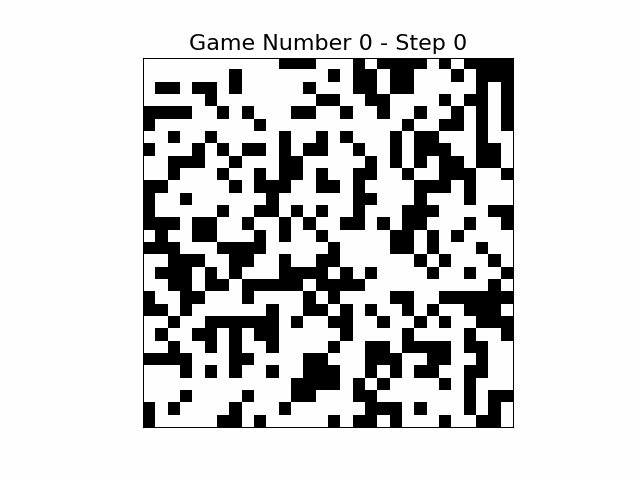

<img src=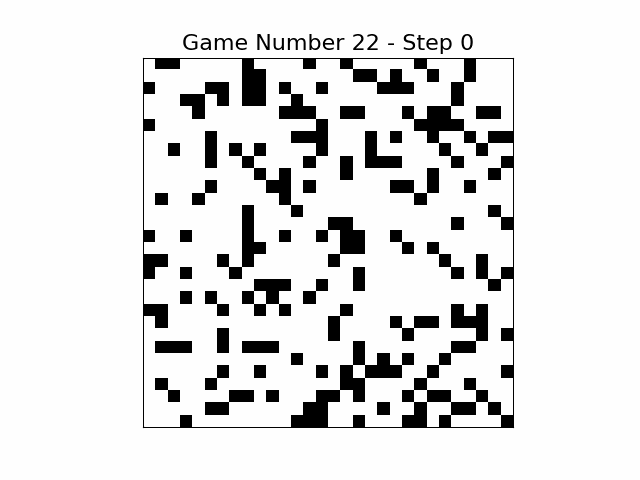 />

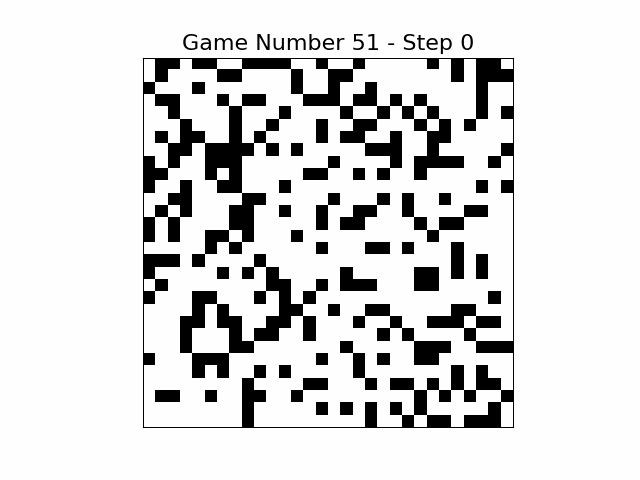

### Large Random Dataset

In [ ]:
# set random seed
np.random.seed(63)

# initialze parameters
grid_size = 30
steps = 300
ngames = 52
init_prob = (0.2, 0.5)

# define states mask
states_mask = slice(4, 4+grid_size*grid_size)

# generate the data
data = generate_data(grid_size, steps, ngames, init_prob)

### Add Game Metadata

In [ ]:
# add meta_data to large random data
data = add_game_meta(data)

In [ ]:
# encode start and endpoints
data["state"] = "intermediate"
start_mask = data["step"] == 0
end_mask = data["step"] == 299
data["state"].iloc[data[start_mask].index] = "startpoint"
data["state"].iloc[data[end_mask].index] = "endpoint"

### Details on the Dataset & Metadata
[Dataset description](https://github.com/matgege/Projection-Space-Exploration/blob/creation/Dataset%20description.pdf)

## Projection

### PCA Projection
Principal Component 1 (PC1): This is the direction (or axis) in the high-dimensional space of the Game of Life states that captures the most variance.

Principal Component 2 (PC2): After PC1, PC2 is the next direction that captures the most variance, orthogonal (perpendicular) to PC1.

In [ ]:
subset = steps * 25
data_subset = data.iloc[:subset]
live_cells_count_idx = 4+grid_size*grid_size
pca = PCA(n_components=2, random_state=SEED)

In [ ]:
%%time
# Using PCA to project the high-dimensional grid states into 2D space, one a subset of the data and measure the time
projected_states_pca = pca.fit_transform(data.iloc[:subset, states_mask])

In [ ]:
projected_states_pca = pd.DataFrame(projected_states_pca, columns=["x", "y"])
projected_states_pca["live_cells_count"] = data.iloc[:subset, live_cells_count_idx]
projected_states_pca["state"] = data.iloc[:subset, -1]
projected_states_pca["step"] = data.iloc[:subset, 0]
projected_states_pca["game_n"] = data.iloc[:subset, 1]

In [ ]:
alt.Chart(projected_states_pca).mark_point(opacity=0.5).encode(
    x=alt.X('x:Q', title="Principal Component 1"),
    y=alt.Y('y:Q', title="Principal Component 2"),
    color=alt.Color("live_cells_count:Q",
                   scale=alt.Scale(scheme='redyellowgreen')),
    shape=alt.Shape('state:N').sort(["intermediate", "startpoint", "endpoint"]),
    tooltip=['step:Q', 'game_n:Q', "state:N", "live_cells_count:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="PCA Projection of 25 Game of Lifes with 300 steps each"
)

In [ ]:
grid_states = data.iloc[:subset, states_mask]
u_map = umap.UMAP(n_components=2, n_neighbors=15, random_state=SEED)

In [ ]:
%%time
# Apply UMAP projection on a subset of the data and measure the time
projected_states_umap = u_map.fit_transform(grid_states)

In [ ]:
projected_states_umap = pd.DataFrame(projected_states_umap, columns=["x", "y"])
projected_states_umap["live_cells_count"] = data.iloc[:subset, live_cells_count_idx]
projected_states_umap["state"] = data.iloc[:subset, -1]
projected_states_umap["step"] = data.iloc[:subset, 0]
projected_states_umap["game_n"] = data.iloc[:subset, 1]

In [ ]:
# Visualize the UMAP projection
alt.Chart(projected_states_umap).mark_point(opacity=0.5).encode(
    x=alt.X('x:Q', title="UMAP Dimension 1"),
    y=alt.Y('y:Q', title="UMAP Dimension 2"),
    color=alt.Color("live_cells_count:Q",
        scale=alt.Scale(scheme='redyellowgreen')),
    shape=alt.Shape('state:N').sort(["intermediate", "startpoint", "endpoint"]),
    tooltip=['step:Q', 'game_n:Q', "state:N", "live_cells_count:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="UMAP Projection"
)

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, random_state=SEED)

In [ ]:
%%time
# Apply TSNE projection on a subset of the data and measure the time
projected_states_tsne = tsne.fit_transform(grid_states)

In [ ]:
projected_states_tsne = pd.DataFrame(tsne.fit_transform(grid_states), columns=["x", "y"])
projected_states_tsne["live_cells_count"] = data.iloc[:subset, live_cells_count_idx]
projected_states_tsne["state"] = data.iloc[:subset, -1]
projected_states_tsne["step"] = data.iloc[:subset, 0]
projected_states_tsne["game_n"] = data.iloc[:subset, 1]

In [ ]:
# Visualize the TSNE projection
alt.Chart(projected_states_tsne).mark_point(opacity=0.5).encode(
    x=alt.X('x:Q', title="t-SNE Dimension 1"),
    y=alt.Y('y:Q', title="t-SNE Dimension 2"),
    color=alt.Color("live_cells_count:Q",
        scale=alt.Scale(scheme='redyellowgreen')),
    shape=alt.Shape('state:N').sort(["intermediate", "startpoint", "endpoint"]),
    tooltip=['step:Q', 'game_n:Q', "state:N", "live_cells_count:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="t-SNE Projection"
)

## Comparison Table
Here's a comparison table for the projection methods applied:

| Method     | Type | Parameters Used              | Computational Efficiency       |
|------------|-------------|------------------------------|-------------------------------|
| PCA        | Linear      | 2 components                 | High                          |
| UMAP       | Non-linear  | n_neighbors=15               | Medium|
| t-SNE       | Non-linear  | perplexity=50               | Medium-Low|

### Detailed Performance Comparison of Dimension Reduction Implementations
[UMAP Docs - Performance Comparison of Dimension Reduction Implementations](https://umap-learn.readthedocs.io/en/latest/benchmarking.html)

### Link States

In [ ]:
subset = steps * 25
data_subset_pca = data.iloc[:subset]
data_subset_tsne = data.iloc[:subset]

In [ ]:
# PCA
data_subset_pca["x"] = projected_states_pca.x
data_subset_pca["y"] = projected_states_pca.y
# t-SNE
data_subset_tsne["x"] = projected_states_tsne.x
data_subset_tsne["y"] = projected_states_tsne.y

### PCA

In [ ]:
point = alt.Chart(data_subset_pca.iloc[:300]).mark_point(opacity=0.75).encode(
    x=alt.X('x:Q', title="Principal Component 1"),
    y=alt.Y('y:Q', title="Principal Component 2"),
    color=alt.Color("step:Q",
                    scale=alt.Scale(scheme='viridis')),
    shape=alt.Shape('state:N').sort(["intermediate", "startpoint", "endpoint"]),
    tooltip=['step:Q', 'game_n:Q', "state:N", "live_cells_count:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="PCA Projection of one Game of Life"
)

line = alt.Chart(data_subset_pca.iloc[:300]).mark_line(
    interpolate="catmull-rom",
    opacity=0.1,
).encode(
    x="x:Q",
    y="y:Q",
    order="step",
    color=alt.value("grey")
).interactive(
).properties(
    width=1_000,
    height=700
)

point + line

In [ ]:
point = alt.Chart(data_subset_pca.iloc[:5*300]).mark_point(opacity=0.5).encode(
    x=alt.X('x:Q', title="Principal Component 1"),
    y=alt.Y('y:Q', title="Principal Component 2"),
    color="game_n:N",
    shape="game_n:N",
    tooltip=["step:Q", "live_cells_count:Q", "game_n:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="PCA Projection of 5 Game of Lifes"
)

line = alt.Chart(data_subset_pca.iloc[:5*300]).mark_line(
    interpolate="catmull-rom",
    opacity=0.15,
).encode(
    x="x:Q",
    y="y:Q",
    order="step",
    color="game_n:N"
).interactive(
).properties(
    width=1_000,
    height=700
)

point + line

### t-SNE

In [ ]:
point = alt.Chart(data_subset_tsne.iloc[:300]).mark_point(opacity=0.75).encode(
    x=alt.X('x:Q', title="t-SNE Component 1"),
    y=alt.Y('y:Q', title="t-SNE Component 2"),
    color=alt.Color("step:Q",
                    scale=alt.Scale(scheme='viridis')),
    shape=alt.Shape('state:N').sort(["intermediate", "startpoint", "endpoint"]),
    tooltip=['step:Q', 'game_n:Q', "state:N", "live_cells_count:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="t-SNE Projection of one Game of Life"
)

line = alt.Chart(data_subset_tsne.iloc[:300]).mark_line(
    interpolate="catmull-rom",
    opacity=0.1,
).encode(
    x="x:Q",
    y="y:Q",
    order="step",
    color=alt.value("grey")
).interactive(
).properties(
    width=1_000,
    height=700
)

point + line

In [ ]:
point = alt.Chart(data_subset_tsne.iloc[:5*300]).mark_point(opacity=0.5).encode(
    x=alt.X('x:Q', title="t-SNE Component 1"),
    y=alt.Y('y:Q', title="t-SNE Component 2"),
    color="game_n:N",
    shape="game_n:N",
    tooltip=["step:Q", "live_cells_count:Q", "game_n:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="t-SNE Projection of 5 Game of Lifes"
)

line = alt.Chart(data_subset_tsne.iloc[:5*300]).mark_line(
    interpolate="catmull-rom",
    opacity=0.15,
).encode(
    x="x:Q",
    y="y:Q",
    order="step",
    color="game_n:N"
).interactive(
).properties(
    width=1_000,
    height=700
)

point + line

### Meta Data Encoding 

### PCA

In [ ]:
subset = steps * 25
subset_of_data_pca, cluster_df_pca = get_projection_dataset_with_meta_data_encoding(pca, "pca", data, subset, states_mask, min_cluster_size = 50, min_samples = 50)

In [ ]:
point = alt.Chart(subset_of_data_pca).mark_point(opacity=0.5).encode(
    x=alt.X('x:Q', title="Principal Component 1"),
    y=alt.Y('y:Q', title="Principal Component 2"),
    color=alt.Color("live_cells_count:Q",
                    scale=alt.Scale(scheme="redyellowgreen")),
    shape=alt.Shape('state:N').sort(["intermediate", "startpoint", "endpoint"]),
    tooltip=['step:Q', 'game_n:Q', "state:N", "live_cells_count:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="PCA Projection of 25 Game of Lifes with 300 steps each"
)

line = alt.Chart(subset_of_data_pca).mark_line(
    interpolate="catmull-rom",
    opacity=0.05,
).encode(
    x="x:Q",
    y="y:Q",
    order="step",
    stroke=alt.Color("game_n:Q", scale=alt.Scale(scheme='warmgreys'))
).interactive(
).properties(
    width=1_000,
    height=700
)

image = alt.Chart(cluster_df_pca).mark_circle().encode(
    x="x",
    y="y",
    size=alt.Color("cluster_size:Q",
        scale=alt.Scale(type='linear', rangeMin=50, rangeMax=250)),
    color=alt.value("black"),
    opacity=alt.value(0.5),
    tooltip=["image", "cluster_size:Q", "cluster:N"]
).interactive(
).properties(
    width=1_000,
    height=700
)

point + line + image

### t-SNE

In [ ]:
subset_of_data_tsne, cluster_df_tsne = get_projection_dataset_with_meta_data_encoding(tsne, "tsne", data, subset, states_mask, min_cluster_size = 50, min_samples = 50)

In [ ]:
point = alt.Chart(subset_of_data_tsne).mark_point(opacity=0.5).encode(
    x=alt.X('x:Q', title="t-SNE Component 1"),
    y=alt.Y('y:Q', title="t-SNE Component 2"),
    color=alt.Color("live_cells_count:Q",
                    scale=alt.Scale(scheme="redyellowgreen")),
    shape=alt.Shape('state:N').sort(["intermediate", "startpoint", "endpoint"]),
    tooltip=['step:Q', 'game_n:Q', "state:N", "live_cells_count:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="t-SNE Projection of 25 Game of Lifes with 300 steps each"
)

line = alt.Chart(subset_of_data_tsne).mark_line(
    interpolate="catmull-rom",
    opacity=0.1,
).encode(
    x="x:Q",
    y="y:Q",
    order="step",
    stroke=alt.Color("game_n:Q", scale=alt.Scale(scheme='warmgreys'))
).interactive(
).properties(
    width=1_000,
    height=700
)

image = alt.Chart(cluster_df_tsne).mark_circle().encode(
    x="x",
    y="y",
    size=alt.Color("cluster_size:Q",
        scale=alt.Scale(type='linear', rangeMin=50, rangeMax=250)),
    color=alt.value("black"),
    opacity=alt.value(0.5),
    tooltip=["image", "cluster_size:Q", "cluster:N"]
).interactive(
).properties(
    width=1_000,
    height=700
)

point + line + image

In [ ]:
projected_states_tsne["live_cells_count"] = data.iloc[:subset, live_cells_count_idx]
projected_states_tsne["periodic"] = data.iloc[:subset, live_cells_count_idx+6]
projected_states_tsne["game_initial_cell_count"] = data.iloc[:subset, live_cells_count_idx+7]
projected_states_tsne["game_n"] = data.iloc[:subset, 1]
projected_states_tsne["step"] = data.iloc[:subset, 0]

# Visualize the TSNE projection
point = alt.Chart(projected_states_tsne).mark_point(opacity=0.4).encode(
    x=alt.X('x:Q', title="t-SNE Dimension 1"),
    y=alt.Y('y:Q', title="t-SNE Dimension 2"),
    size=alt.Color("live_cells_count:Q",
        scale=alt.Scale(type='pow', exponent=2, rangeMin=35, rangeMax=250)),
    color=alt.Color("game_initial_cell_count:Q",
        scale=alt.Scale(type='pow', exponent=1/4, scheme='redyellowgreen')),
    shape=alt.Color("periodic:N"),
    tooltip=["live_cells_count:Q", "game_n:Q", "step:Q"]
).interactive(
).properties(
    width=1_100,
    height=700,
    title="t-SNE Projection"
)

line = alt.Chart(projected_states_tsne).mark_line(
    interpolate="catmull-rom",
    opacity=0.05,
).encode(
    x="x:Q",
    y="y:Q",
    order="step:Q",
    stroke=alt.Color("game_n:Q", scale=alt.Scale(scheme='warmgreys'))
).interactive(
).properties(
    width=1_100,
    height=700
)

point + line

In [ ]:
# Filter the DataFrame to include only games 1, 2, 22, 28, and 51
selected_dataset = data[data['game_n'].isin([1, 2, 22, 28, 51])]

# Define a function to apply to the 'game_n' column
def label_game_type(game_number, label='other'):
    if game_number in [1, 2]:
        return 'chaotic'
    if game_number in [22, 28]:
        return 'periodic'
    elif game_number == 51:
        return 'dying'
    else:
        return label

# Apply the function to create a new 'game type' column
selected_dataset['game type'] = selected_dataset['game_n'].apply(label_game_type)
tsne_projection_selected_dataset = tsne.fit_transform(selected_dataset.iloc[:, states_mask])
selected_dataset['x'] = tsne_projection_selected_dataset[:,0]
selected_dataset['y'] = tsne_projection_selected_dataset[:,1]

In [ ]:
point = alt.Chart(selected_dataset).mark_point(opacity=0.5).encode(
    x=alt.X('x:Q', title="t-SNE Component 1"),
    y=alt.Y('y:Q', title="t-SNE Component 2"),
    color="game type:N",
    shape="game_n:N",
    tooltip=["step:Q", "live_cells_count:Q", "game_n:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="t-SNE Projection of 5 Game of Lifes"
)

line = alt.Chart(selected_dataset).mark_line(
    interpolate="catmull-rom",
    opacity=0.1,
).encode(
    x="x:Q",
    y="y:Q",
    order="step:Q",
    color="game type:N",
    stroke=alt.Color("game_n:N", scale=alt.Scale(scheme='warmgreys'))
).interactive(
).properties(
    width=1_000,
    height=700
)

point + line

### UMAP

In [ ]:
subset_of_data_umap, cluster_df_umap = get_projection_dataset_with_meta_data_encoding(u_map, "umap", data, subset, states_mask, min_cluster_size = 50, min_samples = 50)

In [ ]:
point = alt.Chart(subset_of_data_umap).mark_point(opacity=0.5).encode(
    x=alt.X('x:Q', title="UMAP Component 1"),
    y=alt.Y('y:Q', title="UMAP Component 2"),
    color=alt.Color("live_cells_count:Q",
                    scale=alt.Scale(scheme="redyellowgreen")),
    shape=alt.Shape('state:N').sort(["intermediate", "startpoint", "endpoint"]),
    tooltip=['step:Q', 'game_n:Q', "state:N", "live_cells_count:Q"]
).interactive(
).properties(
    width=1_000,
    height=700,
    title="UMAP Projection of 25 Game of Lifes with 300 steps each"
)

line = alt.Chart(subset_of_data_umap).mark_line(
    interpolate="catmull-rom",
    opacity=0.05,
).encode(
    x="x:Q",
    y="y:Q",
    order="step",
    stroke=alt.Color("game_n:Q", scale=alt.Scale(scheme='warmgreys'))
).interactive(
).properties(
    width=1_000,
    height=700
)

image = alt.Chart(cluster_df_umap).mark_circle().encode(
    x="x",
    y="y",
    size=alt.Color("cluster_size:Q",
        scale=alt.Scale(type='linear', rangeMin=50, rangeMax=250)),
    color=alt.value("black"),
    opacity=alt.value(0.5),
    tooltip=["image", "cluster_size:Q", "cluster:N"]
).interactive(
).properties(
    width=1_000,
    height=700
)

point + line + image

### Details for HDBSCAN parameters
[HDBSCAN difference between parameters](https://stackoverflow.com/questions/67898039/hdbscan-difference-between-parameters)

### Details on the HDBSCAN pictures

Below the first cluster picture shows the game in a late state, the individual living cells are clearly visible. It covers a lot of still lives, like Block and Beehive, but it also covers oscillators like Blinkers.

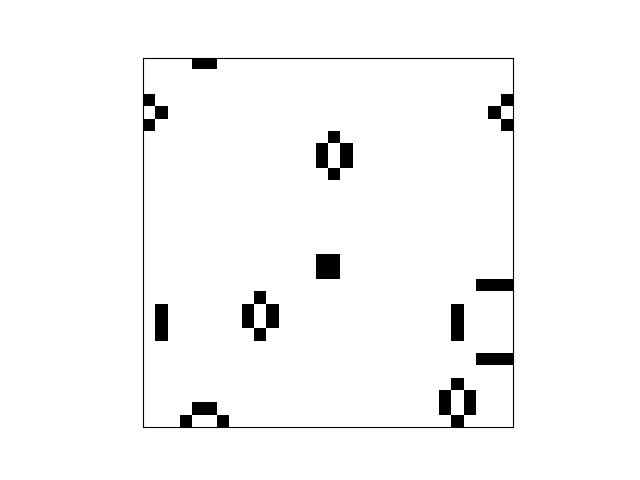

The second cluster picture shows the game in an early to medium stage, the individual living cells are not easily distinguishable and patterns are hard to see. However, black cells show that life is almost always present in this region.

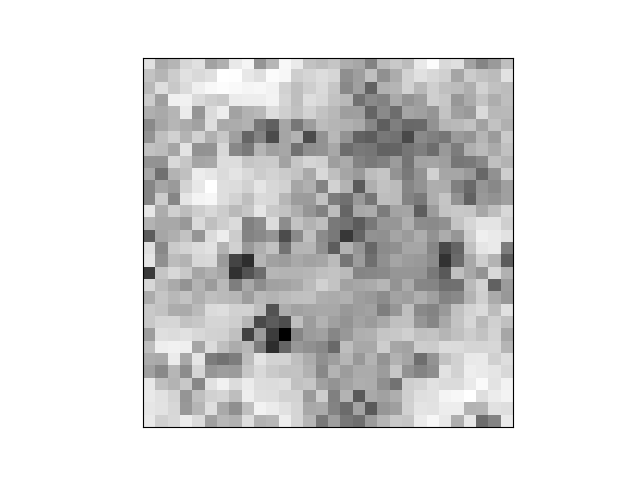

### Note: 
Because the game is invariant to translational shifts, patterns in clusters will appear at random positions in the heat map. This means that if the dataset is too big and the clusters not small enough, we won't see any patterns anymore. For this visualization, it would be good to have relatively small clusters.